In [20]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [26]:
tf.config.run_functions_eagerly(True)

In [3]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [4]:
#loading training data and labels

feature = np.load('data.npy')
label = np.load('label.npy')

In [22]:
#loading testing data and labels

tfeature = np.load('tdata.npy')
tlabel = np.load('tlabel.npy')

In [6]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, 
                         shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

In [7]:
# load the MobileNetV2 model excluding top layers (Transfer Learning)

baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [8]:
# construct the head of the model that will be placed on top of the base model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

In [9]:
# place the head FC model on top of the base model (this will become the actual model we will train)

model = Model(inputs=baseModel.input, outputs=headModel)

In [10]:
# loop over all layers in the base model and freeze them so they will not be updated during the first training process

for layer in baseModel.layers:
    layer.trainable = False

In [1]:
# compile our model

opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer= opt, metrics=["accuracy"])

NameError: name 'Adam' is not defined

In [23]:
label = to_categorical(label, 3)
tlabel = to_categorical(tlabel, 3)

In [27]:
# train the model

H = model.fit(aug.flow(feature, label, batch_size=BS), epochs=EPOCHS, validation_data=(tfeature, tlabel))

C:\Users\Mohamed Ashraf\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
456/456 [==============================] - 1591s 3s/step - loss: 0.3903 - accuracy: 0.8432 - val_loss: 0.1558 - val_accuracy: 0.9519
Epoch 2/10
456/456 [==============================] - 1683s 4s/step - loss: 0.1686 - accuracy: 0.9411 - val_loss: 0.1075 - val_accuracy: 0.9642
Epoch 3/10
456/456 [==============================] - 1601s 4s/step - loss: 0.1282 - accuracy: 0.9545 - val_loss: 0.0891 - val_accuracy: 0.9662
Epoch 4/10
456/456 [==============================] - 1560s 3s/step - loss: 0.1142 - accuracy: 0.9594 - val_loss: 0.0786 - val_accuracy: 0.9737
Epoch 5/10
456/456 [==============================] - 1572s 3s/step - loss: 0.1005 - accuracy: 0.9635 - val_loss: 0.0772 - val_accuracy: 0.9734
Epoch 6/10
456/456 [==============================] - 1824s 4s/step - loss: 0.0951 - accuracy: 0.9675 - val_loss: 0.0716 - val_accuracy: 0.9730
Epoch 7/10
456/456 [==============================] - 1546s 3s/step - loss: 0.0840 - accuracy: 0.9718 - val_loss: 0.0672 - val_accuracy:

In [30]:
print(classification_report(tlabel.argmax(axis=1), predIdxs))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       964
           1       1.00      1.00      1.00      1000
           2       0.99      0.97      0.98       966

    accuracy                           0.99      2930
   macro avg       0.99      0.99      0.99      2930
weighted avg       0.99      0.99      0.99      2930



In [31]:
#saving the model

model.save('mask_detector.h5')

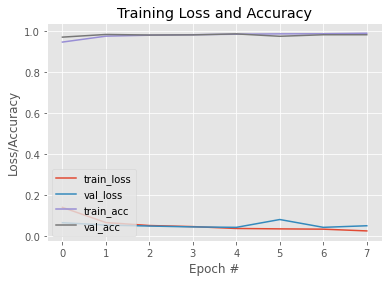

In [33]:
# plot the training loss and accuracy
N = EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("TrainPlot.png")